In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

In [ ]:
# set the base directory path
BASE_DIR = "/content/drive/MyDrive/CSE 281"
ANALYSIS_DIR = os.path.join(BASE_DIR, "analysis")

In [ ]:
# create analysis directory if it doesn't exist
def setup_directories():
    if not os.path.exists(ANALYSIS_DIR):
        os.makedirs(ANALYSIS_DIR)
        print(f"Created analysis directory at: {ANALYSIS_DIR}")
    else:
        print(f"Analysis directory already exists at: {ANALYSIS_DIR}")

    # return the paths for future use
    return {
        "base_dir": BASE_DIR,
        "analysis_dir": ANALYSIS_DIR
    }


In [ ]:
# set up matplotlib style for publication quality
def setup_plot_style():
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'figure.figsize': (10, 6),
        'axes.grid': True,
        'grid.alpha': 0.3
    })

In [ ]:
# initialize everything
def initialize():
    paths = setup_directories()
    setup_plot_style()
    return paths

In [ ]:
# load the DataFrame from the pickle file
df = pd.read_pickle("/content/drive/MyDrive/CSE 280/WattBuyData1999_2024.pkl")

# set start and end year for filtering
start_year = 2016
end_year = 2024

# filter by start and end year using the created_at column
df_filtered = df[(df['created_at'].dt.year >= start_year) &
                (df['created_at'].dt.year <= end_year)]

# filter by rate type
desired_rate_type = 'default rate'
df_filtered = df_filtered[df_filtered['utility_rate_type'] == desired_rate_type]

# filter for PPL Electric Utilities and select relevant columns
filtered_def = df_filtered[df_filtered["utility_name"] == "PPL Electric Utilities"][
    ["utility_name", "created_at", "utility_rate_amount"]
]

# convert rate amount from cents to dollars
filtered_def["utility_rate_amount"] = filtered_def["utility_rate_amount"] / 100

# display the filtered dataset
filtered_def

,utility_name,created_at,utility_rate_amount
18646,PPL Electric Utilities,2016-06-01,0.07491
18647,PPL Electric Utilities,2016-12-01,0.07439
18648,PPL Electric Utilities,2017-06-01,0.08493
18649,PPL Electric Utilities,2017-12-01,0.07463
18650,PPL Electric Utilities,2018-06-01,0.07449
...,...,...,...
18824,PPL Electric Utilities,2021-12-08,0.08941
18825,PPL Electric Utilities,2022-11-02,0.14612
18826,PPL Electric Utilities,2023-09-15,0.12126
18827,PPL Electric Utilities,2023-11-02,0.11028


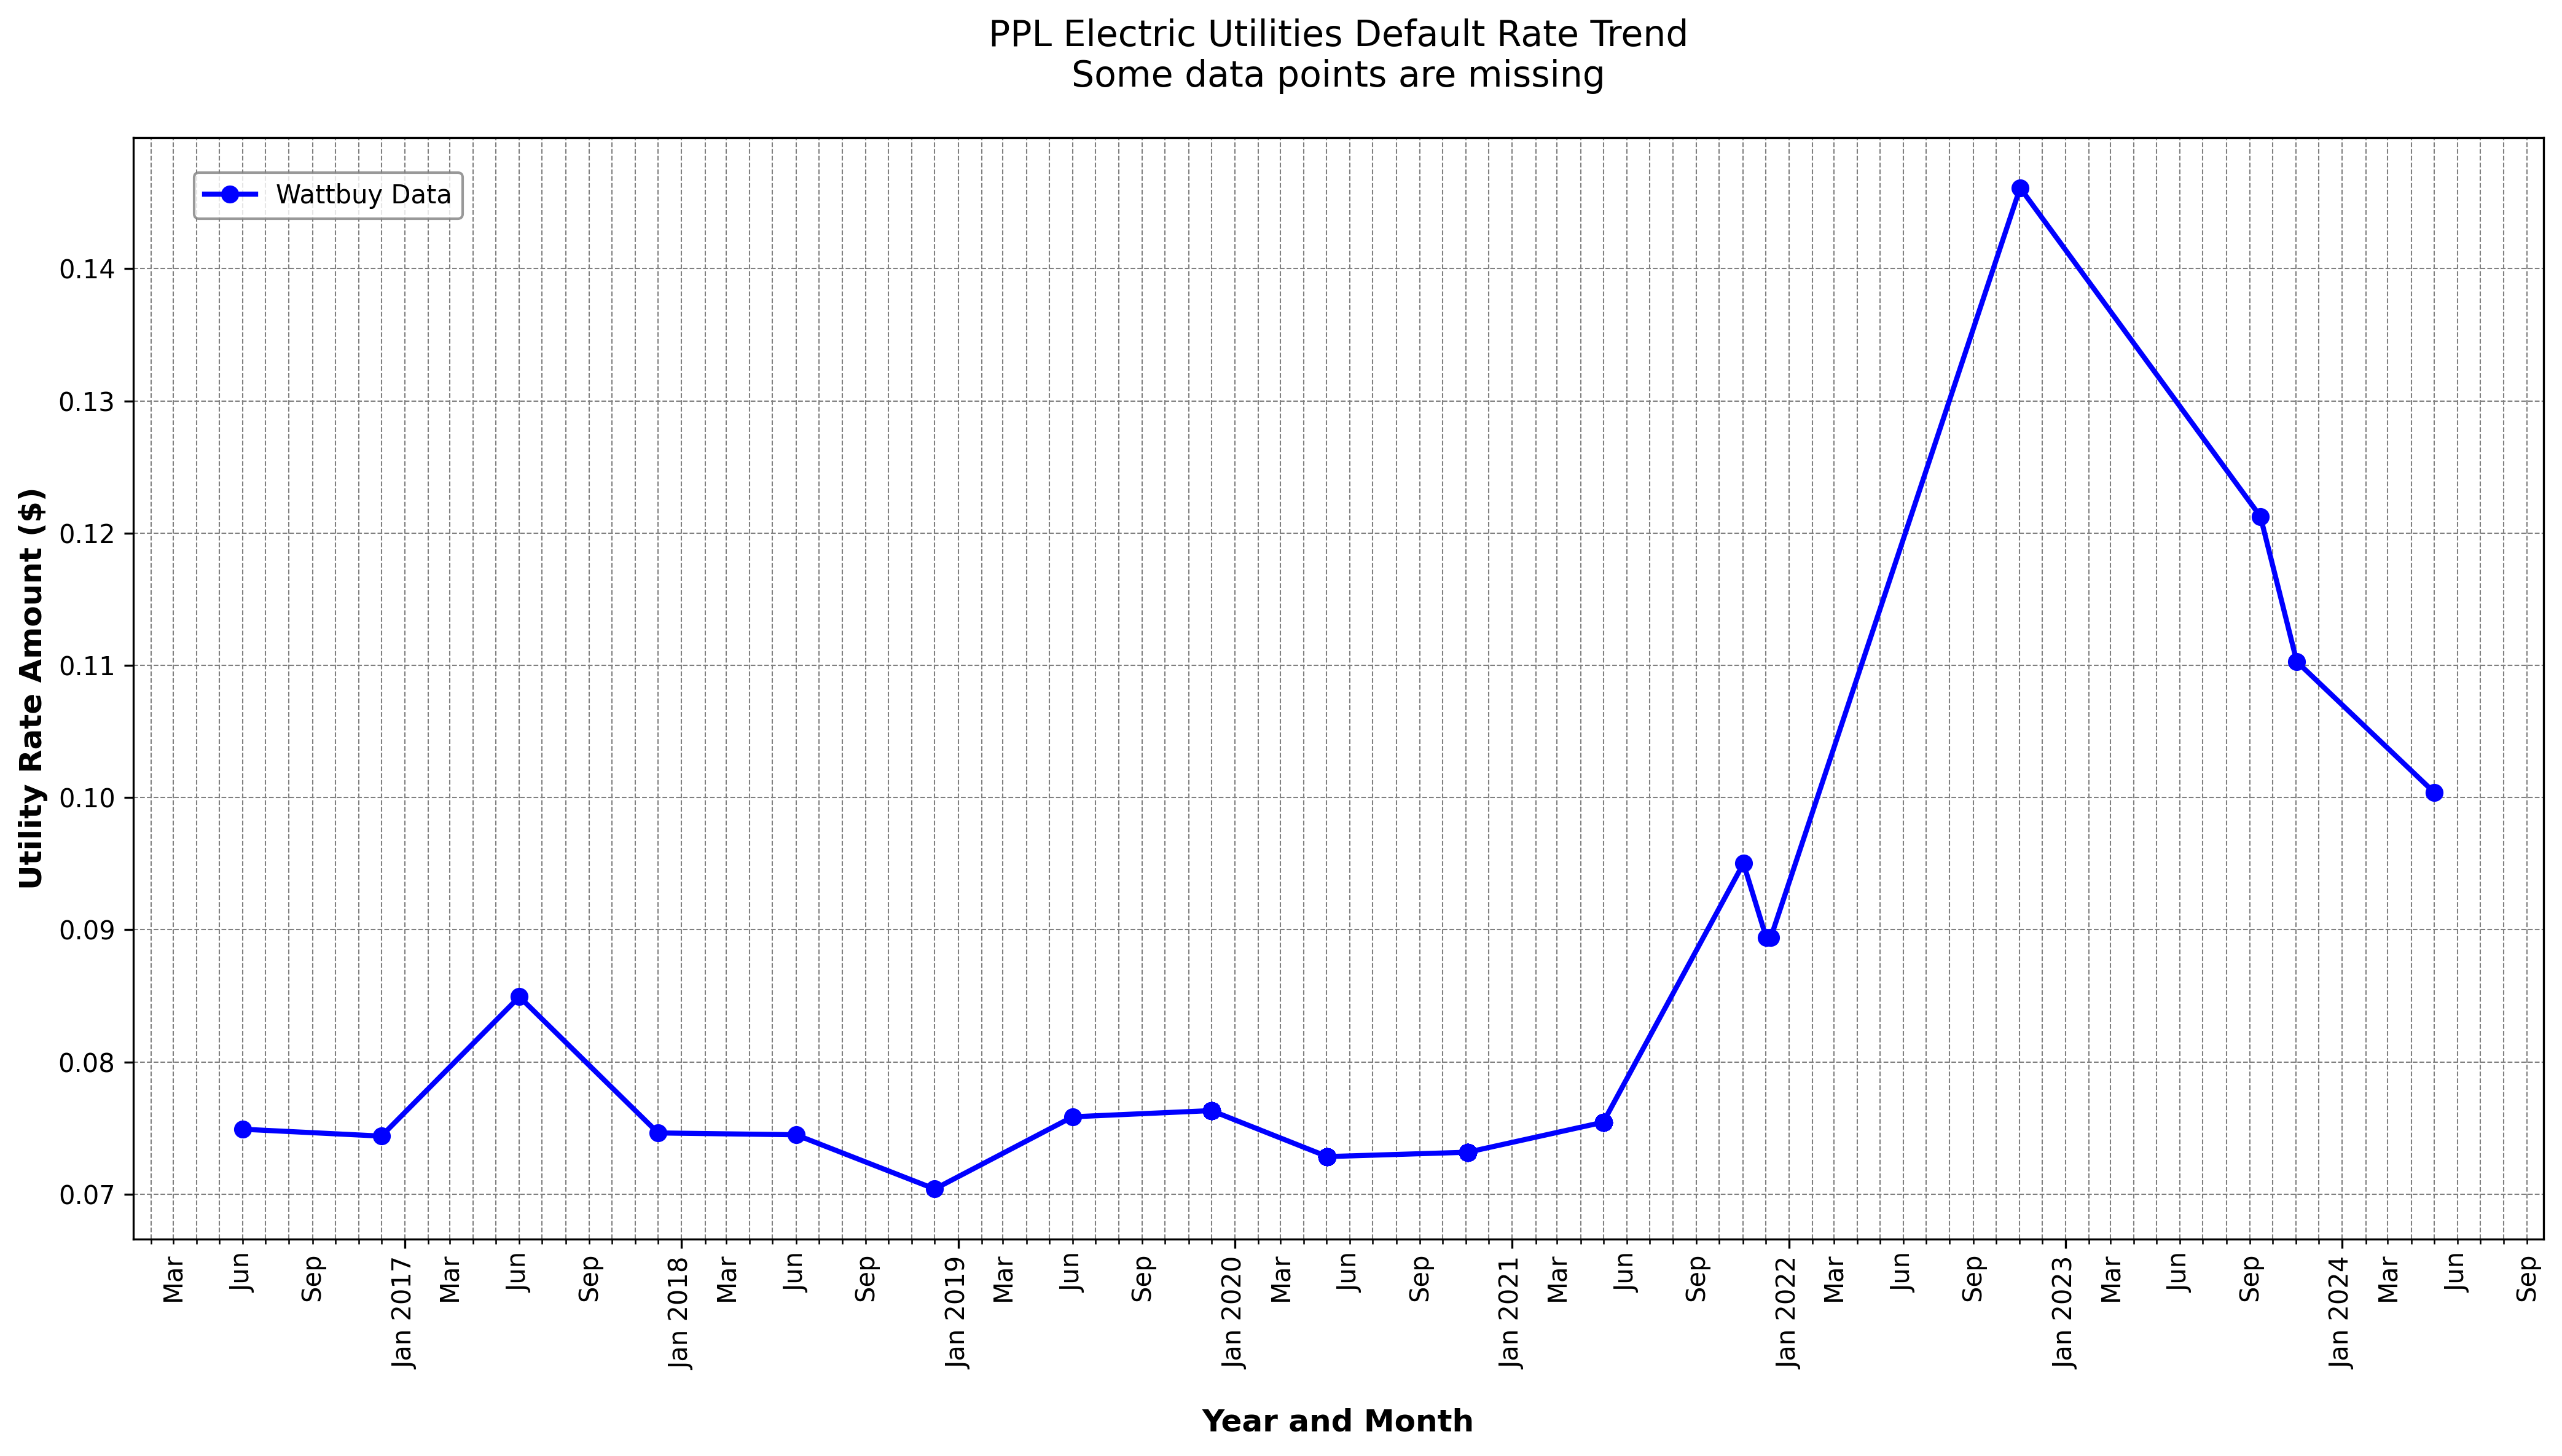

In [ ]:
# custom formatter function for x-axis labels
def custom_formatter(x, pos=None):
    date = mdates.num2date(x)
    if date.month in [3, 6, 9]:
        return date.strftime('%b')
    else:
        return ''

# sort data by date
filtered_def = filtered_def.sort_values(by="created_at")

# create figure and axis with specified size and high dpi for publication quality
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# plot the time series with improved styling
ax.plot(filtered_def["created_at"],
        filtered_def["utility_rate_amount"],
        label="Wattbuy Data",
        marker='o',
        markersize=6,
        color='blue',
        linestyle='-',
        linewidth=2)

# set the x-axis to display major ticks for years and minor ticks for months
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

# rotate x-axis labels
plt.setp(ax.get_xticklabels(which='both'), rotation=90)

# set labels and title
ax.set_xlabel('Year and Month', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Utility Rate Amount ($)', fontsize=12, fontweight='bold')
ax.set_title('PPL Electric Utilities Default Rate Trend\nSome data points are missing',
             fontsize=14, pad=20)

# customize grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# customize legend
ax.legend(frameon=True, facecolor='white', edgecolor='gray',
         loc='upper left', bbox_to_anchor=(0.02, 0.98))

# adjust layout
plt.tight_layout()

# save the figure to analysis directory
plt.savefig(os.path.join(ANALYSIS_DIR, "ppl_default_rate_trend.png"),
            bbox_inches='tight',
            dpi=300)

# display the plot
plt.show()

In [ ]:
# ensure created_at is in datetime format
filtered_def['created_at'] = pd.to_datetime(filtered_def['created_at'])

def impute_daily_data(df):
    # sort and remove duplicates, keeping the last value for each date
    df = df.sort_values('created_at')
    df = df.drop_duplicates(subset='created_at', keep='last')

    # get the first and last dates
    start_date = df['created_at'].min()
    end_date = df['created_at'].max()

    # generate daily date range
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # set created_at as index for reindexing
    df = df.set_index('created_at')

    # reindex with daily dates and forward fill
    df = df.reindex(daily_dates).ffill()

    # reset index and rename
    df = df.reset_index().rename(columns={'index': 'created_at'})

    # resample to monthly frequency (start of month)
    monthly_data = df.set_index('created_at').resample('MS').first().reset_index()

    return monthly_data

# apply the imputation
monthly_filled_def = impute_daily_data(filtered_def)

# display first few rows to verify
print("First few rows of the monthly data:")
print(monthly_filled_def.head())

First few rows of the monthly data:
  created_at            utility_name  utility_rate_amount
0 2016-06-01  PPL Electric Utilities              0.07491
1 2016-07-01  PPL Electric Utilities              0.07491
2 2016-08-01  PPL Electric Utilities              0.07491
3 2016-09-01  PPL Electric Utilities              0.07491
4 2016-10-01  PPL Electric Utilities              0.07491


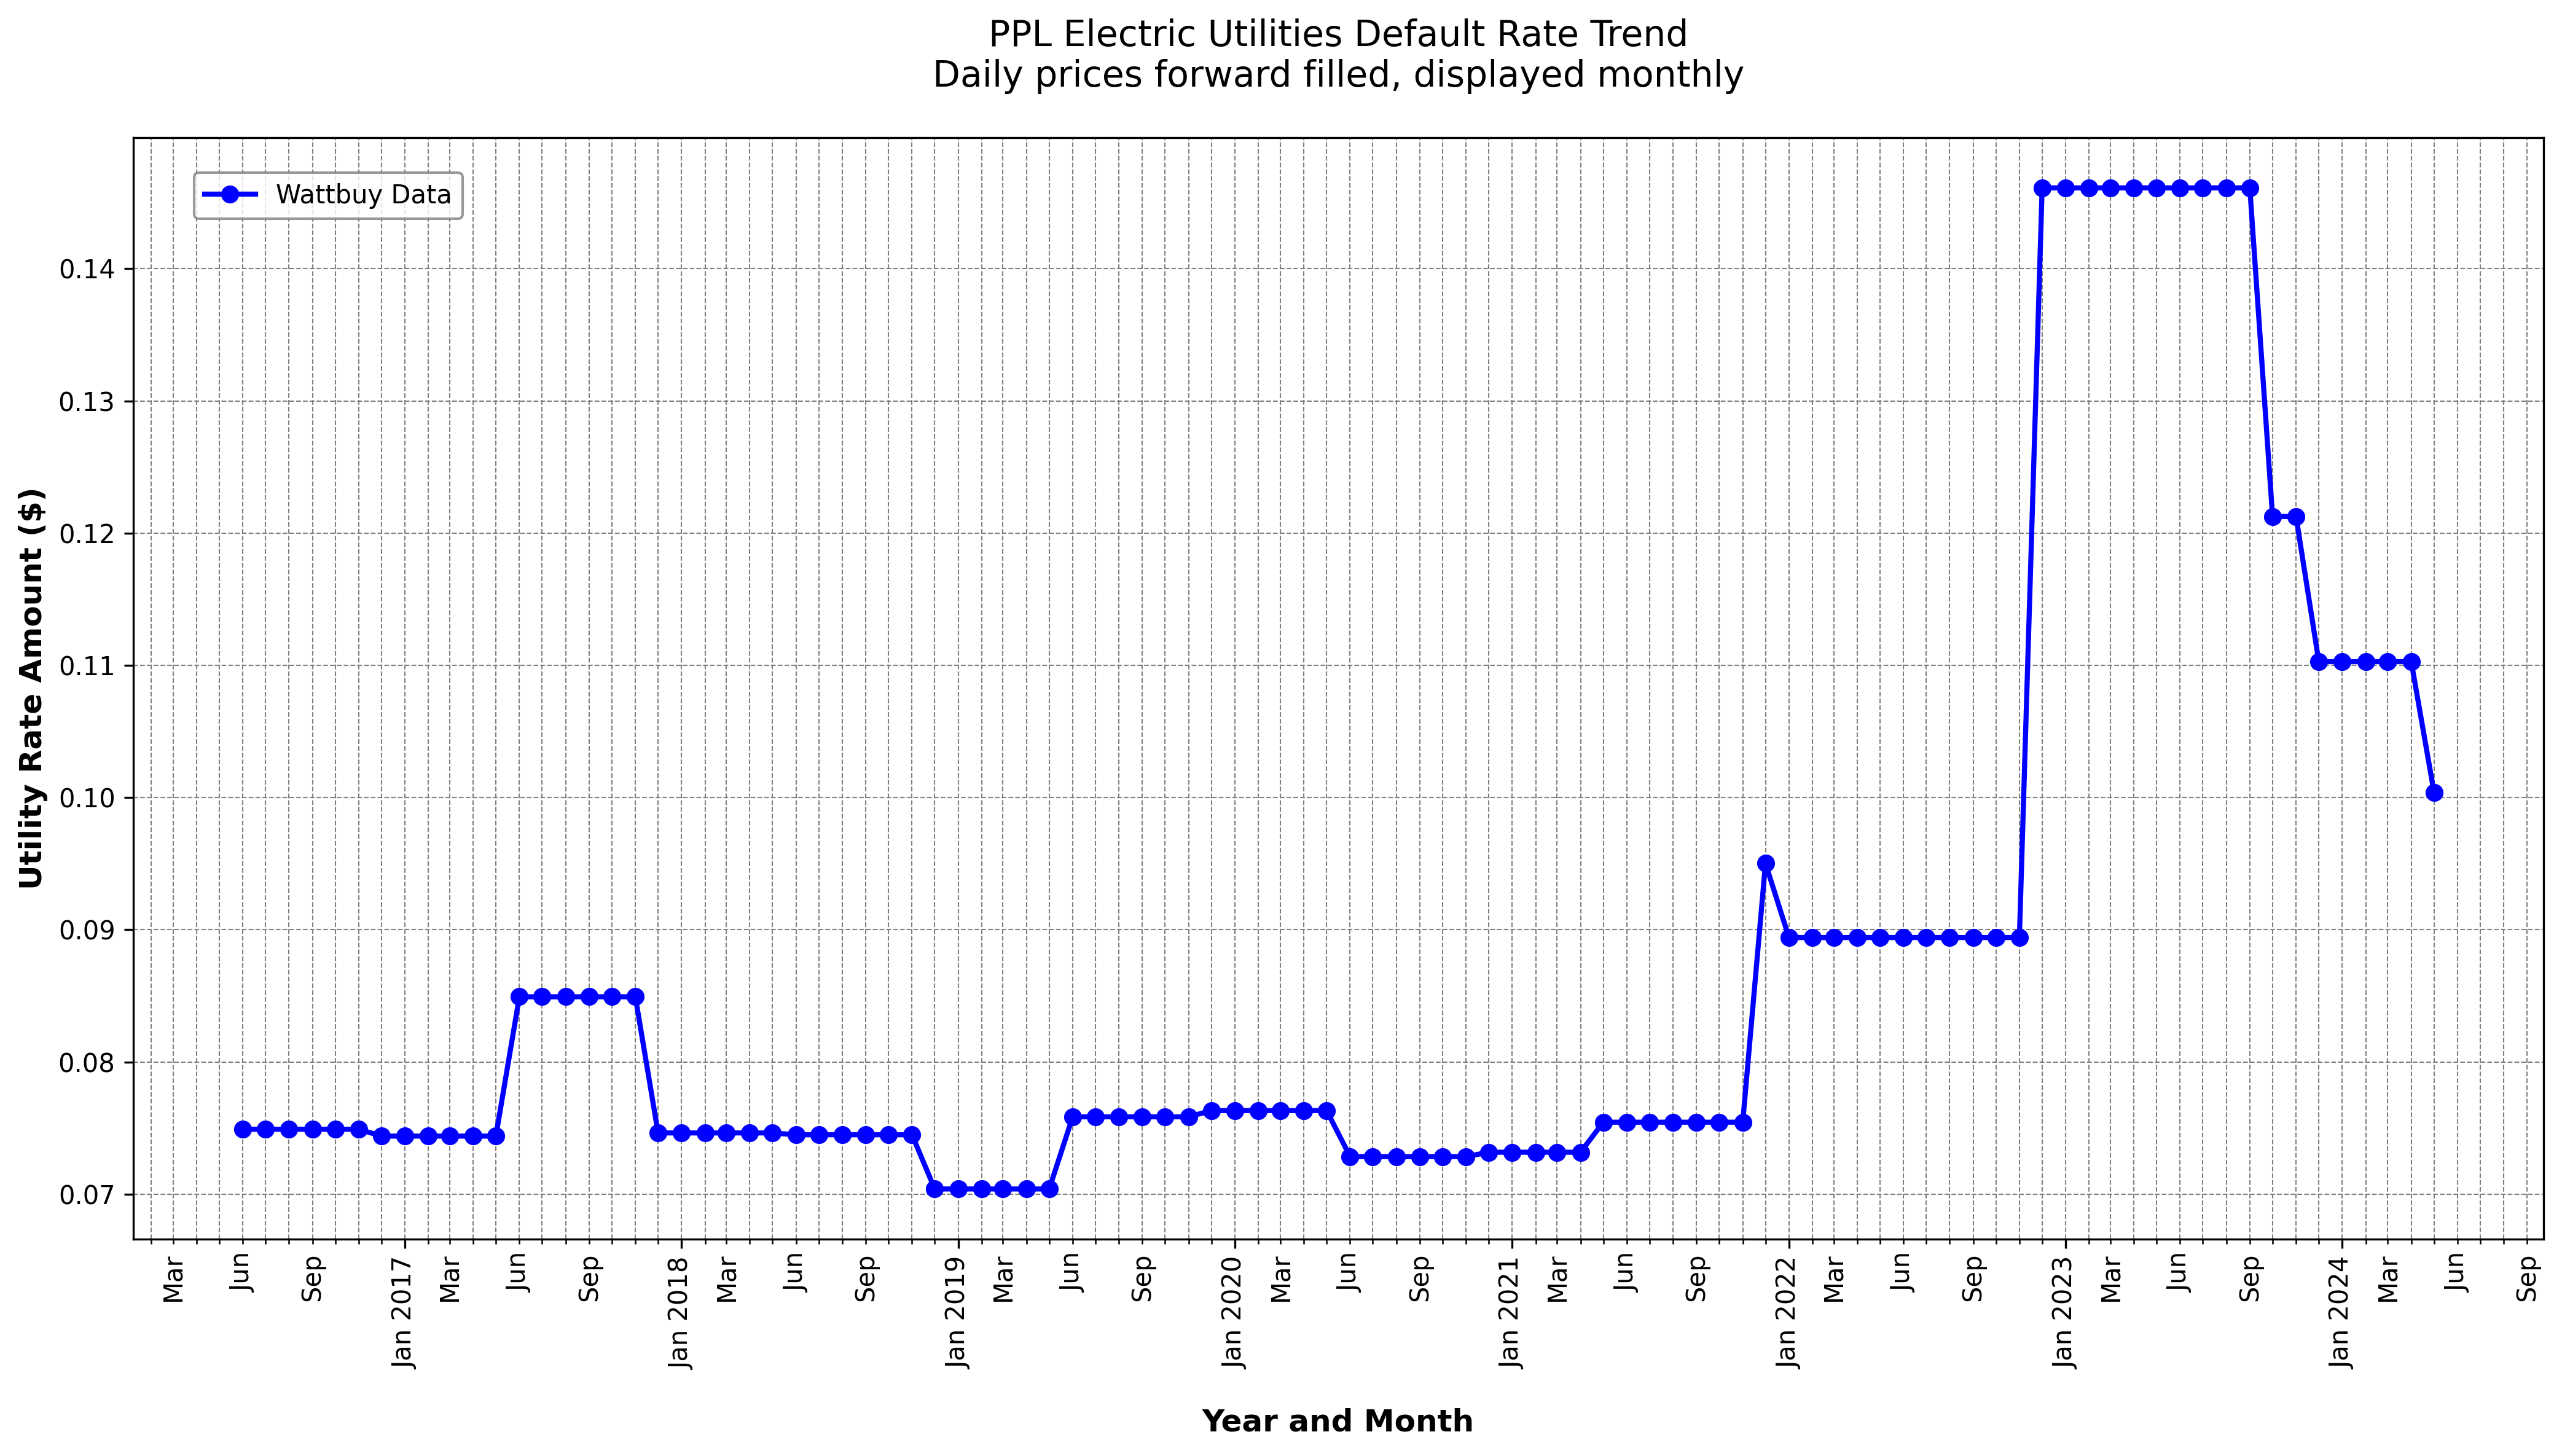

In [ ]:
# sort data by date
monthly_filled_def = monthly_filled_def.sort_values(by="created_at")

# create figure and axis with specified size and high dpi for publication quality
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# plot the time series
ax.plot(monthly_filled_def["created_at"],
        monthly_filled_def["utility_rate_amount"],
        label="Wattbuy Data",
        marker='o',
        markersize=6,
        color='blue',
        linestyle='-',
        linewidth=2)

# set the x-axis to display major ticks for years and minor ticks for months
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

# rotate x-axis labels
plt.setp(ax.get_xticklabels(which='both'), rotation=90)

# set labels and title
ax.set_xlabel('Year and Month', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Utility Rate Amount ($)', fontsize=12, fontweight='bold')
ax.set_title('PPL Electric Utilities Default Rate Trend\nDaily prices forward filled, displayed monthly',
             fontsize=14, pad=20)

# customize grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# customize legend
ax.legend(frameon=True, facecolor='white', edgecolor='gray',
         loc='upper left', bbox_to_anchor=(0.02, 0.98))

# adjust layout
plt.tight_layout()

# save the figure to analysis directory
plt.savefig(os.path.join(ANALYSIS_DIR, "ppl_default_rate_trend_monthly.png"),
            bbox_inches='tight',
            dpi=300)

# display the plot
plt.show()

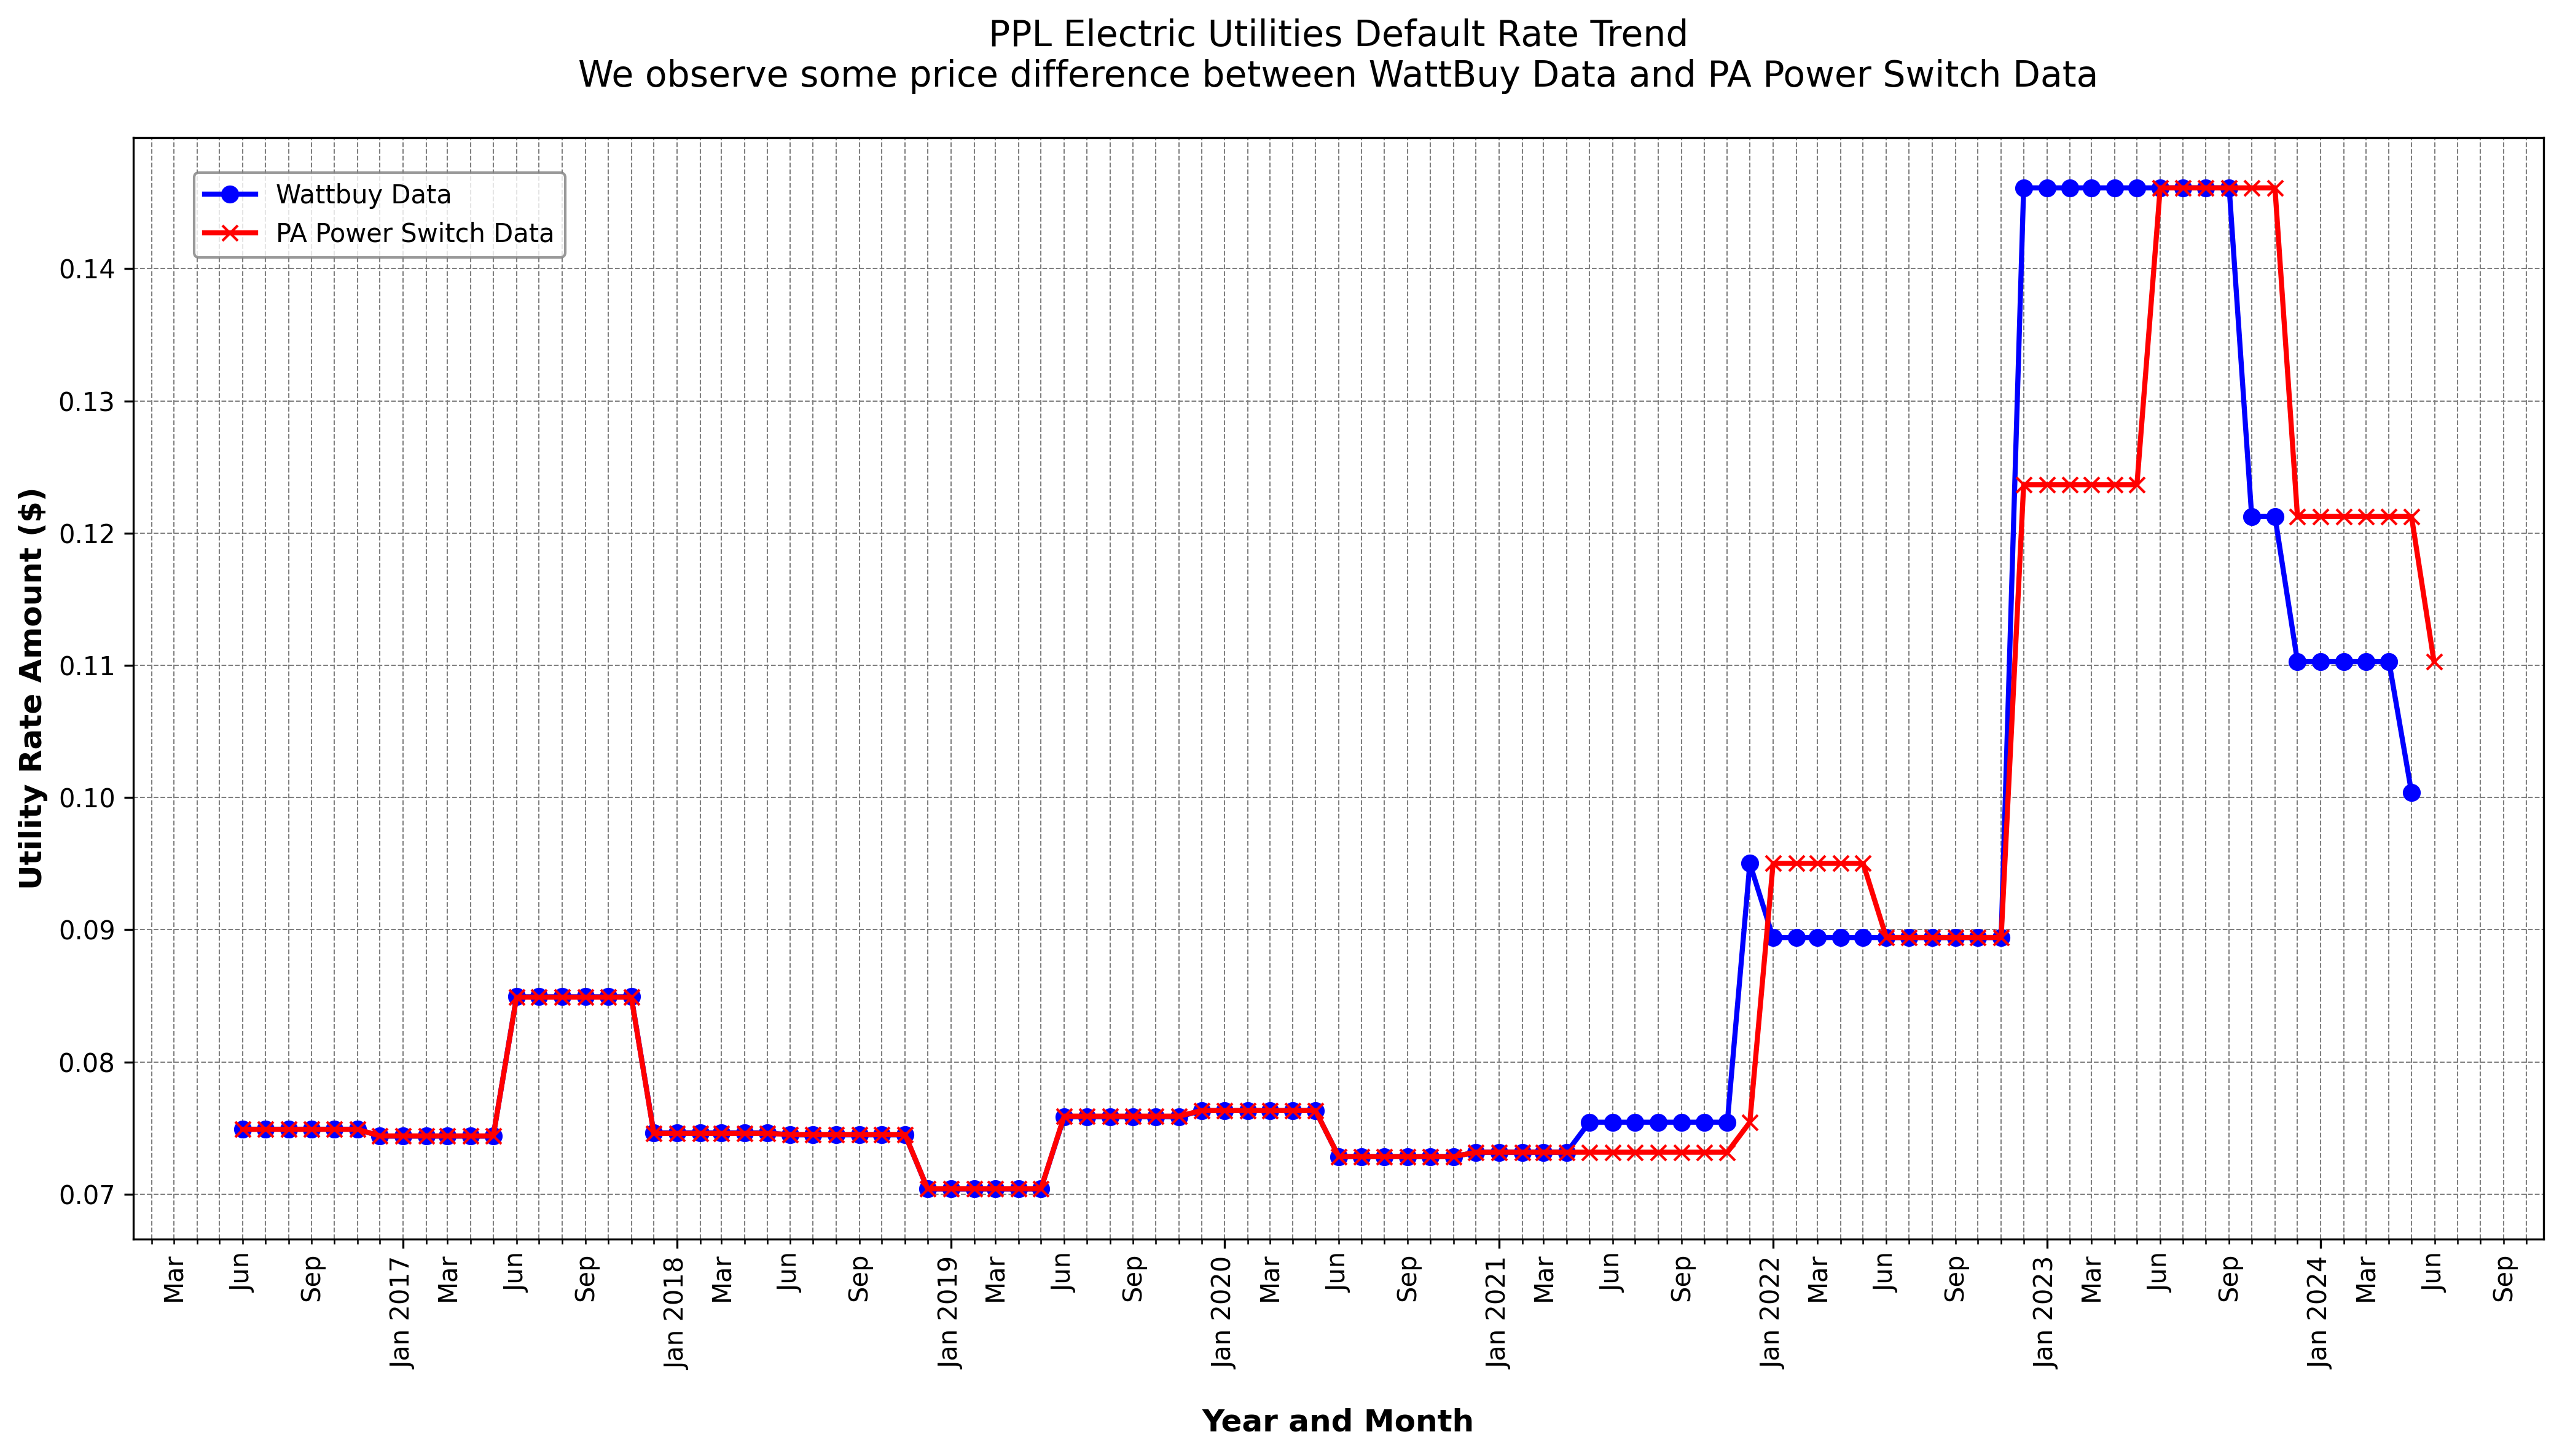

In [ ]:
# read the PA Power Switch Data
paps_data = pd.read_csv("/content/drive/MyDrive/CSE 280/utility_provider_rates_filled.csv")

# convert created_at to datetime for consistency
paps_data["created_at"] = pd.to_datetime(paps_data["created_at"])

# sort both datasets by date
monthly_filled_def = monthly_filled_def.sort_values(by="created_at")
paps_data = paps_data.sort_values(by="created_at")

# create figure and axis
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

# plot both datasets
ax.plot(monthly_filled_def["created_at"],
        monthly_filled_def["utility_rate_amount"],
        label="Wattbuy Data",
        marker='o',
        markersize=6,
        color='blue',
        linestyle='-',
        linewidth=2)

ax.plot(paps_data["created_at"],
        paps_data["utility_rate_amount"],
        label="PA Power Switch Data",
        marker='x',
        markersize=6,
        color='red',
        linestyle='-',
        linewidth=2)

# set the x-axis to display major ticks for years and minor ticks for months
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

# rotate x-axis labels
plt.setp(ax.get_xticklabels(which='both'), rotation=90)

# set labels and title
ax.set_xlabel('Year and Month', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Utility Rate Amount ($)', fontsize=12, fontweight='bold')
ax.set_title('PPL Electric Utilities Default Rate Trend\nWe observe some price difference between WattBuy Data and PA Power Switch Data',
             fontsize=14, pad=20)

# customize grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# customize legend
ax.legend(frameon=True, facecolor='white', edgecolor='gray',
         loc='upper left', bbox_to_anchor=(0.02, 0.98))

# adjust layout
plt.tight_layout()

# save the figure
plt.savefig(os.path.join(ANALYSIS_DIR, "default_rate_trend_comparison.png"),
            bbox_inches='tight',
            dpi=300)

# display the plot
plt.show()